# Airi-ConvNet
Autor: Gabriel Dornelles Monteiro, abril de 2022. Notebook nº4.

Vejamos o desempenho da nossa rede convolucional comparada a nossos modelos anteriores

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [41]:
# Boilerplate do notebook anterior
train_dataset = CIFAR10(root="./", download=True, train=True) 
val_dataset = CIFAR10(root="./", download=True, train=False) 

train_images = np.array([np.array(train_dataset[i][0]) for i in range(len(train_dataset))])
train_targets = np.array([np.array(train_dataset[i][1]) for i in range(len(train_dataset))])

val_images = np.array([np.array(val_dataset[i][0]) for i in range(len(val_dataset))])
val_targets = np.array([np.array(val_dataset[i][1]) for i in range(len(val_dataset))])

original_val = val_images
#transforma nossas imagens 32x32x3 em vetor linha 3072
# train_images = np.reshape(train_images, (train_images.shape[0], -1))
# val_images = np.reshape(val_images, (val_images.shape[0], -1))

# média do array train_images no eixo 0, eixo onde os índices são as imagens 3072
mean_image = np.mean(train_images, axis = 0)

# mean_image é um array de floats, para operação fazer sentido nossas imagens precisam ser também.
train_images = train_images.astype(float)
train_images -= mean_image

val_images = val_images.astype(float)
val_images -= mean_image
# train_images shape: (50000, 3072)

Files already downloaded and verified
Files already downloaded and verified


Carregamos o modelo treinado:

In [42]:
import sys
import dill as pickle
sys.path.insert(0, "airi")

with open('airi/DemoConvNet.airi', 'rb') as f:
    model = pickle.load(f)

In [44]:
# cria um dicionário com o nome das classes e uma lista contendo as imagens associadas no dataset de validação 
empty_lists = [ [] for _ in range(10)]
per_class_images = dict(zip(classes,empty_lists))

for idx, image in enumerate(val_images):
    image_target = classes[val_targets[idx]]
    per_class_images[image_target].append(image)

correct = 0
scores_dict = {}

for idx, class_name in enumerate(classes):
    correct = 0
    for X in per_class_images[class_name]:
        X = X[None,:,:,:]
        softmax = model(X)

        if np.argmax(softmax) == idx:
            correct+=1

    scores_dict.update({class_name: correct/1000})

scores_dict = dict(sorted(scores_dict.items(), key = lambda item: item[1]))
print(scores_dict)

{'bird': 0.41, 'cat': 0.428, 'dog': 0.461, 'deer': 0.474, 'car': 0.63, 'frog': 0.642, 'truck': 0.671, 'horse': 0.68, 'plane': 0.727, 'ship': 0.746}


Temos uma média de **58.7%** de precisão geral para nossa ConvNet construida do zero. É possivel alcançar cerca de 60-62% com este modelo, se dispor do tempo necessário para treina-lo.

Comparando ao modelo anterior Two Layer Neural Net:

| Classe  |Precisão ConvNet|  Precisão Two Layer NN|  Precisão Softmax-Classsifier |
|---------|---|---|---|
| cat |0.428| 0.262  |0.211   | 5.1%
| bird |0.41| 0.359  | 0.201  | **15.8%**
| dog |0.461| 0.395  | 0.348  |  4.7%
| deer |0.474|0.462   | 0.279  | **18.3%**
| plane |  0.727|0.495  | 0.492  | 0.3%
| truck |0.671 |0.534  | 0.499  | 3.5%
| frog | 0.642|0.556  | 0.545  | 1.1%
| horse | 0.68|0.568  | 0.388   | **18%**
| car | 0.63|0.672  | 0.468  | **20.4%**
| ship |0.746 |0.695   | 0.556  | **13.9%**

Tivemos um enorme ganho de precisão na classe Plane, já que agora conseguimos definir algumas características do avião, e não só depender da cor azul, que está muito presente também nos aviões, assim como caminhões.

Tivemos um ganho enorme para os gatos também, apesar de ainda não conseguirmos definir muito bem o que é um, saltamos de 26% para quase 43% de precisão.

Tivemos pequenos ganhos nas outras classes e uma perda na classe carro, que era extremamente dominante nos neurônios que visualizamos da Two Layer NN

---

# Visualizando o que acontece dentro de uma ConvNet

Vejamos uma inferência para uma imagem qualquer de validação:

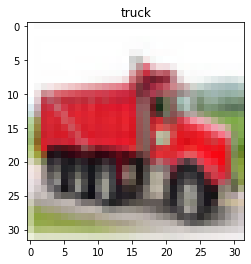

Predicted: truck
Probability: 0.9999966846894813


In [35]:
sample_n = 609 # 603-good bird  604-good car 609-good truck
sample = val_images[sample_n]
plt.imshow(original_val[sample_n])
plt.title(classes[val_targets[sample_n]])
plt.show()

sample = sample[None,:,:,:] # add batch dimension
softmax = model(sample)
result = np.argmax(softmax)
print(f"Predicted: {classes[result]}")
print(f"Probability: {softmax[0][result]}")

Agora vejamos os filtros aprendidos pelo nosso modelo:

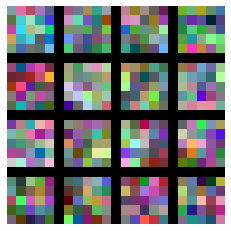

In [36]:
from math import sqrt, ceil
def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    Reshape a 4D tensor of image data to a grid for easy visualization.
    Inputs:
    - Xs: Data of shape (N, H, W, C)
    - ubound: Output grid will have values scaled to the range [0, ubound]
    - padding: The number of blank pixels between elements of the grid
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                # grid[y0:y1, x0:x1] = Xs[next_idx]
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    return grid
filters = model.model[0].conv
#figure(figsize=(2, 2), dpi=30)
grid = visualize_grid(filters.transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
#plt.gcf().set_size_inches(5, 5)
plt.show()

Como nossos filtros são pequenos (5x5), é difícil ver o que ele está procurando, mas vejamos o que cada um deles ativa:

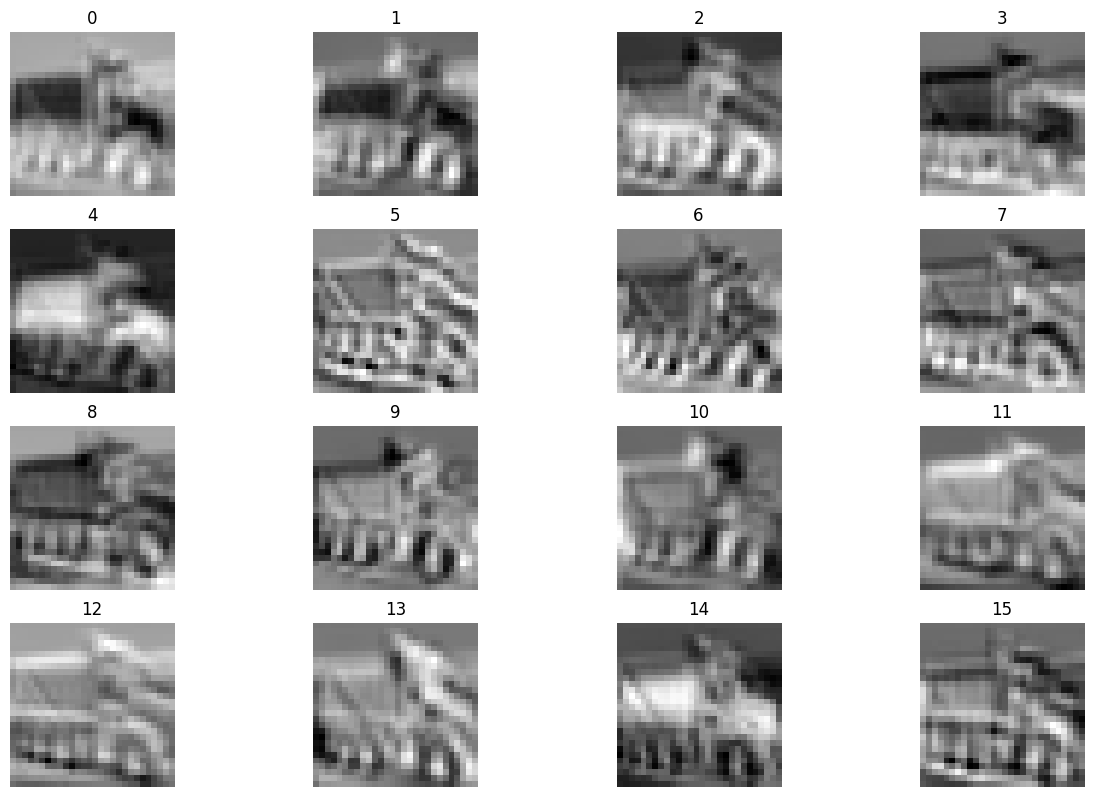

In [37]:
from matplotlib.pyplot import figure
%matplotlib inline

x = sample
x = x.transpose(0,3,1,2)
filters = model.model[0](x)[0]

figure(figsize=(15, 10), dpi=100)
for i in range(filters.shape[0]):
    plt.subplot(4,4, i +1)
    map_ = filters[i]
    w_min, w_max = np.min(map_), np.max(map_)
    wimg = 255.0 * (map_ - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'), cmap='gray')
    plt.title(i)
    plt.axis("off")


Temos que branco são ativações altas, enquanto preto são ativações baixas.

Vemos no filtro 0 por exemplo, pouca ativação na lataria do carro, já que o vermelho, não é uma cor presente na matriz do filtro 0

Vejamos agora a segunda camada de convolução:

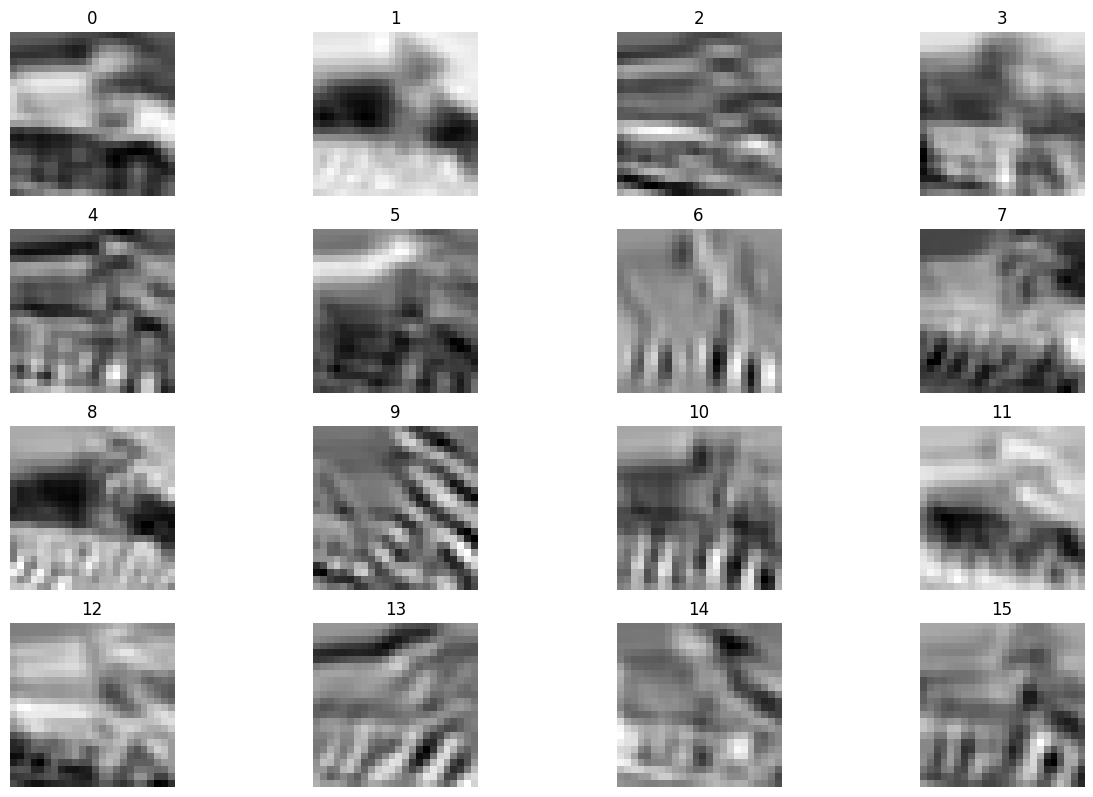

In [38]:
from matplotlib.pyplot import figure
%matplotlib inline

x = sample
x = x.transpose(0,3,1,2)
for layer in model.model[:3]:
    x = layer.forward(x)

filters = x[0]
# filters = model.forward()

figure(figsize=(15, 10), dpi=100)
for i in range(filters.shape[0]):
    plt.subplot(4,4, i +1)
    map_ = filters[i]
    w_min, w_max = np.min(map_), np.max(map_)
    wimg = 255.0 * (map_ - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'), cmap='gray')
    plt.title(i)
    plt.axis("off")


Esta é a ultima camada antes de entrarmos nas camadas lineares, e ela serve como alimentação das lineares que virão. Veja que em alguns destes neurônios, ainda vemos claramente um caminhão, e por isso o modelo nos entrega com 99% de confiança a classe correta.

As camadas lineares tem como função agora meramente receber as ativações no formato como estas chegam, e mapear até a probabilidade correta, estas que já definiram caracteristicas da classe, como podemos ver a região das rodas com uma alta ativação (em branco).

As convoluções tem como objetivo evidenciar características da imagem que está sendo passada ao modelo, e alimentar as camadas lineares com as caracteristicas do objeto na imagem, e não mais, de certa maneira, checando qual template gera maior ativação, como tinhamos nos modelos puramente baseado em camadadas lineares. Deste modo, as convoluções aprendem "formas" e "padrões" que ao convoluir com a imagem, evidenciem esta caracteristica e ignore o que não é relevante.

Para visualizarmos melhor veremos como é por dentro de uma ConvNet treinada no ImageNet, está não treinada com imagens 32x32, mas 224x224.

Artigo original: https://arxiv.org/pdf/1311.2901.pdf


![image](https://user-images.githubusercontent.com/56324869/162348894-11c49bdf-8782-4abd-a060-972717bb33bf.png)

Aqui vemos algumas formas e padrões aprendidos, como cores, gradientes, retas e outros formatos, que ao convoluir a imagem, devem evidenciar suas características

![image](https://user-images.githubusercontent.com/56324869/162349059-d620f784-ee88-47a6-a2eb-33d4f1286481.png)

Aqui começamos a ver se desenhar as características de algumas partes da imagem, vemos alta ativação em formas geométricas, como as linhas e círculos das texturas.

![image](https://user-images.githubusercontent.com/56324869/162349351-614f03bf-f781-4d56-a657-56d31b474e25.png)

Na terceira camada de convolução, já vemos definidamente características importantes das imagens, como as rodas do veículo, os rostos humanos, e mesmo letras, algo que não é passado como objetivo do aprendizado, mas perceba como o modelo julga importante conhecer as letras, pois é uma característica importante de determinadas classes no ImageNet, como sinais de transito, teclado de computador, super mercados e muitos outros. 

![image](https://user-images.githubusercontent.com/56324869/162349945-2134b56a-8544-4c83-82bd-3116db264c04.png)

Aqui na quarta camada, já estamos proximos das camadas lineares, o modelo já começa a dar ênfase nas patas dos pássaros, rostos de animais, letras, roupas.


![image](https://user-images.githubusercontent.com/56324869/162350190-8ef73dde-f9d9-4dde-98fa-798132635155.png)

A última camada antes das camadas lineares, temos de maneira muita definida rostos humanos, rostos de animais, letreiros, rodas etc.


-------

Está é a abordagem moderna de como o computador compreende imagens, através do aprendizado de características, e representações da mesma procurando por suas caracterísiticas. Utilizando estas representações, alimentamos o classificador que vimos no softmax classifier e two layer neural net, definidos por camadas lineares que irão mapear estas caracterísitcas até a probabilidade associada da classe. Desta maneira, o pipeline que temos pode ser pensado como:

![image](https://user-images.githubusercontent.com/56324869/162350685-617e1e9b-e4d1-4a7b-9eb7-217d228c8420.png)

# IMPORTANTE
Essas são apenas algumas visualizações, diferentes modelos tendem a aprender diferentes formas de abstração. Veja como diferentes modelos olham para diferentes regiões e características de uma mesma imagem:

![image](https://user-images.githubusercontent.com/56324869/162352648-8f347b07-1ea0-42b7-81bb-c157080e83c3.png)

## Não acabamos por aqui!

Re-inventar a roda não é recomendado, e devemos saber quando "Re-inventar" vale a pena a nivel de aprendizado. 

Para os próximos notebooks, utilizaremos o framework PyTorch, e verá que este, é modular, e extremamente similar a como fizemos aqui, porém com uma quantidade gigante de blocos e funcionalidades!;

Veremos as ResNets e construiremos modelos robustos e atuais para classificação!